In [2]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import legacy
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
dataset_dir = 'data/tomatect'
base_dir = 'data/splits'
train_pct = 0.8
validation_pct = 0.15
test_pct = 0.05
img_width = 256
img_height = 256
batch_size = 32

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [4]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    shuffle=True,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    seed=123,
    shuffle=True,
    image_size=(img_height,img_width),
    batch_size=batch_size
)


dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    shuffle=False,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 8000 files belonging to 10 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-06-12 09:43:56.329671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-12 09:43:56.329960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 1500 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


In [5]:
class_names = dataset_train.class_names

dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_validation = dataset_validation.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_test = dataset_test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [89]:
class_names

['bacterial_spot',
 'early_blight',
 'healthy',
 'late_blight',
 'leaf_mold',
 'mosaic_virus',
 'septoria_leaf_spot',
 'spider_mites',
 'target_spot',
 'yellow_curl_virus']

In [6]:
data_scaling = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
   tf.keras.layers.experimental.preprocessing.RandomRotation(0.9),
   tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)    
])

In [7]:
train_ds = dataset_train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
input_shape = (batch_size, img_width, img_height, 3)
n_classes = 10

In [9]:
model = tf.keras.models.Sequential([
    data_scaling,
  #  data_augmentation,
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax'),
])

In [10]:
model.build(input_shape=input_shape)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    dataset_train,
    batch_size=32,
    #steps_per_epoch=len(dataset_test)// batch_size,
    validation_data=dataset_validation,
    verbose=1,
    epochs=25,
)

Epoch 1/25
250/250 [==============================] - 120s 478ms/step - loss: 0.4710 - accuracy: 0.8304 - val_loss: 0.7104 - val_accuracy: 0.7547
Epoch 2/25
250/250 [==============================] - 105s 419ms/step - loss: 0.4182 - accuracy: 0.8518 - val_loss: 0.5680 - val_accuracy: 0.7887
Epoch 3/25
250/250 [==============================] - 112s 448ms/step - loss: 0.3198 - accuracy: 0.8891 - val_loss: 0.5469 - val_accuracy: 0.8220
Epoch 4/25
250/250 [==============================] - 122s 488ms/step - loss: 0.2527 - accuracy: 0.9136 - val_loss: 0.3826 - val_accuracy: 0.8800
Epoch 5/25
250/250 [==============================] - 124s 497ms/step - loss: 0.2321 - accuracy: 0.9178 - val_loss: 0.4119 - val_accuracy: 0.8680
Epoch 6/25
250/250 [==============================] - 119s 476ms/step - loss: 0.2048 - accuracy: 0.9283 - val_loss: 0.3942 - val_accuracy: 0.8773
Epoch 7/25
250/250 [==============================] - 118s 470ms/step - loss: 0.1638 - accuracy: 0.9440 - val_loss: 0.3161 -

In [17]:
scores = model.evaluate(dataset_test)
print(f'Test Loss: {scores[0]:.3f}')
print(f'Test Accuracy: {scores[1]:.3f}')

16/16 [==============================] - 2s 119ms/step - loss: 0.2835 - accuracy: 0.9220
Test Loss: 0.284
Test Accuracy: 0.922


In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/gv/329dcxbs405bx2j0y5mdlxvm0000gn/T/tmp6r9etcev/assets


INFO:tensorflow:Assets written to: /var/folders/gv/329dcxbs405bx2j0y5mdlxvm0000gn/T/tmp6r9etcev/assets
2023-06-10 17:08:46.014887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-10 17:08:46.015057: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-10 17:08:46.020328: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gv/329dcxbs405bx2j0y5mdlxvm0000gn/T/tmp6r9etcev
2023-06-10 17:08:46.023038: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-06-10 17:08:46.023047: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/gv/329dcxbs405bx2j0y5mdlxvm0000gn/T/tmp6r9etcev
2023-06-10 17:08:46.033356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-06-10 17:08:46.036075: I tensorflow/cc/saved_model/load

In [29]:
# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

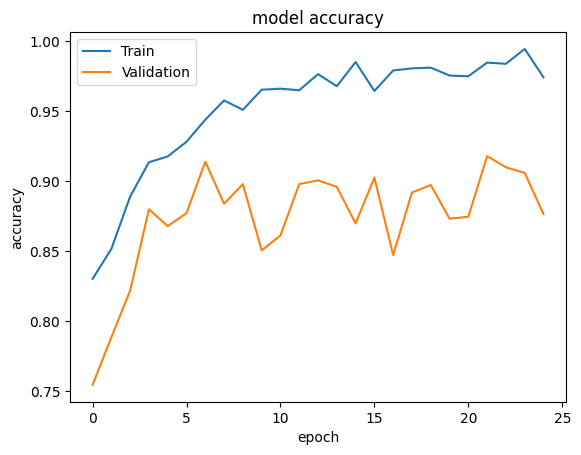

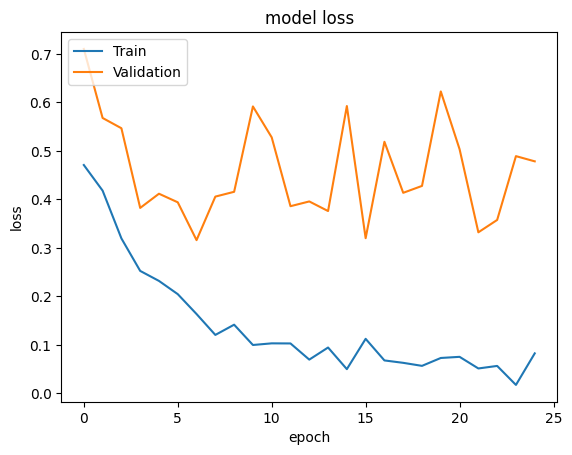

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [19]:
label_test = dataset_test.map(lambda image, label:label)

In [20]:
label_test = np.concatenate([label.numpy() for _, label in dataset_test])

In [21]:
label_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6,

In [23]:
y_pred = model.predict(dataset_test)
y_pred = np.argmax(y_pred, axis=1)

16/16 [==============================] - 2s 99ms/step


In [24]:
con_mat = confusion_matrix(label_test, y_pred)
print(con_mat)

[[42  0  0  0  0  0  0  0  2  6]
 [ 0 42  0  3  1  0  1  0  1  2]
 [ 0  0 49  0  0  0  0  1  0  0]
 [ 0  2  0 48  0  0  0  0  0  0]
 [ 0  0  0  0 48  0  1  0  0  1]
 [ 0  0  0  0  1 47  0  2  0  0]
 [ 1  1  0  2  5  1 37  0  3  0]
 [ 0  0  0  0  0  0  0 49  1  0]
 [ 0  1  0  0  0  0  0  0 49  0]
 [ 0  0  0  0  0  0  0  0  0 50]]


In [31]:
from sklearn.metrics import precision_score, accuracy_score, recall_score
# Calculate precision
precision = precision_score(label_test, y_pred, average='macro')

# Calculate accuracy
accuracy = accuracy_score(label_test, y_pred)

# Calculate recall
recall = recall_score(label_test, y_pred, average='macro')


In [60]:
dataset_train.class_indices

AttributeError: '_PrefetchDataset' object has no attribute 'class_indices'

In [29]:
accuracy

0.922

In [32]:
precision

0.9260825249204097

In [33]:
recall

0.922

In [69]:
# # Example dataset loading
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

# # Extract the labels before applying augmentation
train_labels = [label.numpy() for _, label in dataset_train]

# # Apply augmentation transformations to the dataset
# augmented_dataset = train_dataset.map(augmentation_function)

# Iterate over the augmented dataset to get the labels
augmented_labels = [label.numpy() for _, label in train_ds]

# Concatenate the original and augmented labels
all_labels = np.concatenate((train_labels, augmented_labels))

2023-06-12 11:34:30.223745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [110]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 

for image_name in os.listdir("private/tomatect/spider_mites") : 
    img_n = os.path.join("private/tomatect/spider_mites", image_name)
    if(img_n.endswith('.jpg') or img_n.endswith('.png') or img_n.endswith('.jpeg')) :
        img = image.load_img(img_n, target_size=(256,256))
        # imgplot = plt.imshow(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        images = np.vstack([x])
        classes = model.predict(images, batch_size=32)
        print("Hasil : ", class_names[np.argmax(classes)])
# print("Hasil:", class_names[classes]round((classes[0][0])*100),"%")
# print("Iris Versicolour:", round((classes[0][1])*100),"%")
# print("Iris Virginica:", round((classes[0][2])*100),"%")
# print("Iris Setosa:", round((classes[0][3])*100),"%")
# print("Iris Versicolour:", round((classes[0][4])*100),"%")
# print("Iris Virginica:", round((classes[0][5])*100),"%")
# print("Iris Setosa:", round((classes[0][6])*100),"%")
# print("Iris Versicolour:", round((classes[0][7])*100),"%")
# print("Iris Virginica:", round((classes[0][8])*100),"%")
# print("Iris Virginica:", round((classes[0][9])*100),"%")

1/1 [==============================] - 0s 41ms/step
Hasil :  early_blight
1/1 [==============================] - 0s 24ms/step
Hasil :  late_blight
1/1 [==============================] - 0s 24ms/step
Hasil :  late_blight
1/1 [==============================] - 0s 25ms/step
Hasil :  late_blight
1/1 [==============================] - 0s 27ms/step
Hasil :  target_spot
1/1 [==============================] - 0s 25ms/step
Hasil :  early_blight
1/1 [==============================] - 0s 26ms/step
Hasil :  early_blight
1/1 [==============================] - 0s 25ms/step
Hasil :  late_blight
1/1 [==============================] - 0s 26ms/step
Hasil :  late_blight
1/1 [==============================] - 0s 24ms/step
Hasil :  late_blight
1/1 [==============================] - 0s 24ms/step
Hasil :  early_blight
1/1 [==============================] - 0s 23ms/step
Hasil :  late_blight
1/1 [==============================] - 0s 24ms/step
Hasil :  late_blight
1/1 [==============================] - 0s 23ms/

In [25]:
label_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6,

In [128]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 9, 0, 6, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 1, 0, 1, 3, 1, 1, 6, 1, 1, 6, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 6, 1, 1,
       1, 1, 1, 1, 3, 1, 9, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 6, 8, 4, 4, 4, 4, 6, 4, 4, 4, 6, 8, 6, 4, 8, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 4, 4, 4, 6, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6,

In [129]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

In [134]:
accuracy_score(label_test, y_pred)

0.908

In [76]:
test_iter = iter(data_test)

In [77]:
element = next(test_iter)
element

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
 array([[[[144., 138., 140.],
          [126., 120., 122.],
          [138., 132., 134.],
          ...,
          [142., 131., 135.],
          [106.,  95.,  99.],
          [129., 118., 122.]],
 
         [[141., 135., 137.],
          [135., 129., 131.],
          [151., 145., 147.],
          ...,
          [122., 111., 115.],
          [116., 105., 109.],
          [138., 127., 131.]],
 
         [[143., 137., 139.],
          [132., 126., 128.],
          [139., 133., 135.],
          ...,
          [142., 131., 135.],
          [133., 122., 126.],
          [114., 103., 107.]],
 
         ...,
 
         [[121., 112., 115.],
          [131., 122., 125.],
          [126., 117., 120.],
          ...,
          [113., 103., 102.],
          [126., 116., 115.],
          [121., 111., 110.]],
 
         [[126., 117., 120.],
          [142., 133., 136.],
          [126., 117., 120.],
          ...,
          [126., 116., 115.

In [78]:
for element in test_iter:
    print(element)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[135., 128., 136.],
         [129., 122., 130.],
         [125., 118., 126.],
         ...,
         [120., 113., 121.],
         [120., 113., 121.],
         [121., 114., 122.]],

        [[129., 122., 130.],
         [126., 119., 127.],
         [125., 118., 126.],
         ...,
         [125., 118., 126.],
         [123., 116., 124.],
         [121., 114., 122.]],

        [[126., 119., 127.],
         [126., 119., 127.],
         [128., 121., 129.],
         ...,
         [127., 120., 128.],
         [120., 113., 121.],
         [114., 107., 115.]],

        ...,

        [[124., 122., 127.],
         [122., 120., 125.],
         [119., 117., 122.],
         ...,
         [ 64.,  59.,  66.],
         [ 68.,  63.,  70.],
         [ 73.,  68.,  75.]],

        [[121., 119., 124.],
         [120., 118., 123.],
         [119., 117., 122.],
         ...,
         [ 62.,  57.,  64.],
         [ 68.,  63.,  70.],
       